전체 데이터 개수: 60
     essay_id                      topic            source  \
0     ETS_002                 Smart Cars         ETS_Model   
1  GEMINI_020          Autonomous Robots  Gemini_Generated   
2  GEMINI_003                   Altruism  Gemini_Generated   
3     ETS_007                 Cane Toads         ETS_Model   
4    USER_009  Transient Lunar Phenomena     Student_Draft   

                                          essay_text  word_count  score  \
0  The reading passage proposes that smart cars w...         196     30   
1  The provided text and audio materials provide ...         214     29   
2  The lecture contradicts the reading passage's ...         168     28   
3  The reading passage and the lecture provide co...         211     30   
4  The reading passage and the lecture provide co...         218     22   

  grammar_errors  
0            NaN  
1            Low  
2            Low  
3            NaN  
4           High  
Train: 48, Val: 6, Test: 6


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3357856413.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


학습을 시작합니다...


Epoch,Training Loss,Validation Loss,Rmse
1,694.787800,734.923889,27.109480
2,648.593500,646.038086,25.417279
3,606.603200,568.527527,23.843815
4,522.441700,511.228607,22.610365
5,440.318600,468.743988,21.650497
6,414.742000,436.565186,20.894142
7,419.478200,414.449188,20.358025
8,381.158200,398.846100,19.971132
9,339.954300,389.914581,19.746255
10,378.376000,386.910004,19.670028


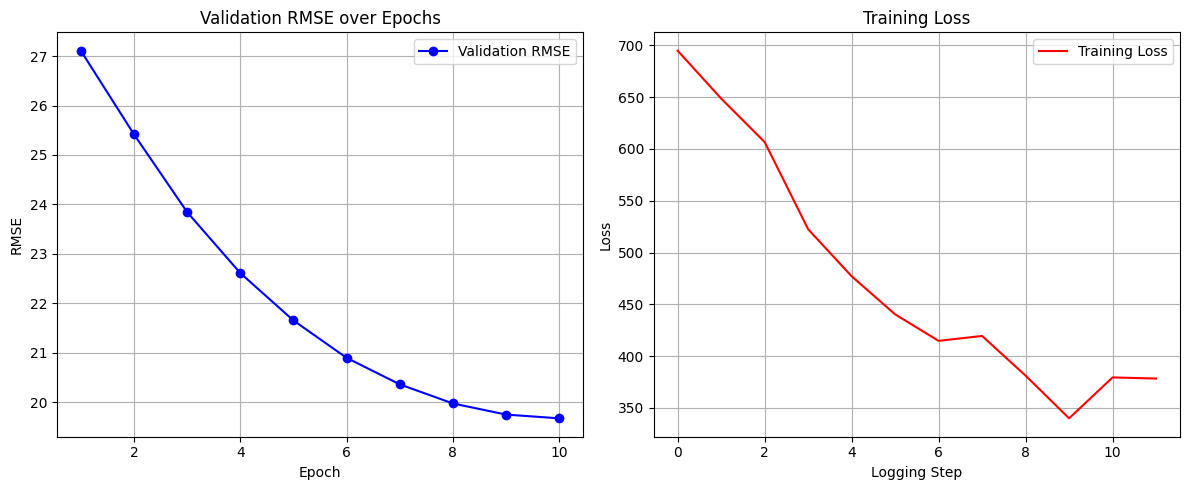

학습 곡선 그래프가 저장되었습니다 (learning_curve.png)
Mounted at /content/drive
구글 드라이브(/content/drive/MyDrive/toefl_model)에 저장을 시도합니다...
✅ 모델 저장 및 동기화 완료!
Mounted at /content/drive


In [1]:
# ==========================================
# 0. 환경 설정 및 라이브러리 설치 (수정됨)
# ==========================================
# 에러 방지를 위해 accelerate와 transformers를 최신 버전으로 업데이트합니다.
# 실행 후 반드시 [런타임] -> [세션 다시 시작]을 눌러주세요!
!pip install -U accelerate transformers torch datasets scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import os

# ==========================================
# 1. 데이터 로드 및 전처리
# ==========================================
# 파일이 없으면 업로드 (안전장치)
if not os.path.exists("toefl_assignment4.csv"):
    from google.colab import files
    print("업로드된 데이터 파일이 없습니다. 파일을 선택해주세요.")
    uploaded = files.upload()

df = pd.read_csv("toefl_assignment4.csv")

# 데이터 확인
print(f"전체 데이터 개수: {len(df)}")
print(df.head())

# [평가 기준 충족] 데이터셋 분할: Train(80%) / Val(10%) / Test(10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# 평가 단계에서 사용하기 위해 Test Set을 따로 저장 (필수)
test_df.to_csv("test_dataset.csv", index=False)

# HuggingFace Dataset 포맷으로 변환
train_dataset = Dataset.from_pandas(train_df[['essay_text', 'score']])
val_dataset = Dataset.from_pandas(val_df[['essay_text', 'score']])
test_dataset = Dataset.from_pandas(test_df[['essay_text', 'score']])

# ==========================================
# 2. 토크나이저 및 모델 준비
# ==========================================
model_name = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    tokenized = tokenizer(examples["essay_text"], truncation=True, padding="max_length", max_length=512)
    tokenized["labels"] = [float(score) for score in examples["score"]]
    return tokenized

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

# ==========================================
# 3. 학습 설정 및 실행
# ==========================================

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    if isinstance(predictions, tuple):
        predictions = predictions[0]

    predictions = np.squeeze(predictions)

    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    return {"rmse": rmse}

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,

    # [평가 기준 충족] 학습 과정의 투명성
    eval_strategy="epoch",
    save_strategy="epoch",

    # [평가 기준 충족] Validation 성능 모니터링
    load_best_model_at_end=True,
    metric_for_best_model="rmse",
    greater_is_better=False,

    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# 학습 시작
print("학습을 시작합니다...")
train_result = trainer.train()

# ==========================================
# 4. 학습 곡선 시각화 (Learning Curve)
# ==========================================
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_rmse = [x['eval_rmse'] for x in history if 'eval_rmse' in x]
epochs = range(1, len(eval_rmse) + 1)

plt.figure(figsize=(12, 5))

# Validation RMSE Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_rmse, 'b-o', label='Validation RMSE')
plt.title('Validation RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# Training Loss Curve
if train_loss:
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, 'r-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Logging Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("learning_curve.png")
plt.show()
print("학습 곡선 그래프가 저장되었습니다 (learning_curve.png)")

# ==========================================
# 5. 모델 저장 (Google Drive)
# ==========================================
# [평가 기준 충족] 재현 가능성: 모델 가중치 저장

# 1. 로컬 저장 (백업용)
model.save_pretrained("./my_toefl_scorer_model")
tokenizer.save_pretrained("./my_toefl_scorer_model")

# 2. 구글 드라이브 저장 (제출용)
from google.colab import drive
import shutil

drive.mount('/content/drive')

# 경로 설정
drive_save_path = "/content/drive/MyDrive/toefl_model"

try:
    print(f"구글 드라이브({drive_save_path})에 저장을 시도합니다...")
    model.save_pretrained(drive_save_path)
    tokenizer.save_pretrained(drive_save_path)
    # 확실한 동기화를 위해 flush
    drive.flush_and_unmount()
    print("✅ 모델 저장 및 동기화 완료!")
    # 다시 마운트 (이후 작업을 위해)
    drive.mount('/content/drive')
except Exception as e:
    print(f"❌ 구글 드라이브 저장 실패: {e}")
    print("로컬에 저장된 './my_toefl_scorer_model' 폴더를 PC로 다운로드하세요.")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving toefl_assignment4.csv to toefl_assignment4.csv
